In [92]:
import numpy as np
import wandb
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
import shutil
import os                              # Import the 'os' module for changing directories
os.chdir('/content/drive/MyDrive/FL')  # Change the directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import Subset, DataLoader, random_split

from FederatedLearningProject.data.cifar100_loader import get_cifar100
import FederatedLearningProject.checkpoints.checkpointing as checkpointing
from FederatedLearningProject.training.FL_training import train_server_model_editing
from FederatedLearningProject.experiments import models

In [84]:
import importlib
import FederatedLearningProject.data.cifar100_loader
import FederatedLearningProject.checkpoints.checkpointing
import FederatedLearningProject.training.FL_training
import FederatedLearningProject.experiments.models

importlib.reload(FederatedLearningProject.data.cifar100_loader)
importlib.reload(FederatedLearningProject.checkpoints.checkpointing)
importlib.reload(FederatedLearningProject.training.FL_training)
importlib.reload(FederatedLearningProject.experiments.models)

<module 'FederatedLearningProject.experiments.models' from '/content/drive/MyDrive/FL/FederatedLearningProject/experiments/models.py'>

In [60]:
### TRAIN SPLIT WITH EVALUATION ###

valid_split_perc = 0.2
# train_set, val_set, test_set = get_cifar100(valid_split_perc=valid_split_perc)

val_set = torch.load('FederatedLearningProject/masks/val_set.pth', weights_only=False)
train_set = torch.load('FederatedLearningProject/masks/train_set.pth', weights_only=False)
test_set = torch.load('FederatedLearningProject/masks/test_set.pth', weights_only=False)


train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

In [101]:
### CARICAMENTO DEL MODELLO ###

### ---- IID ---- ###
#model = models.LinearFlexibleDino(num_layers_to_freeze=12)
#model_checkpoint = torch.load("FederatedLearningProject/checkpoints/FL_IID_300round/dino_vits_16_iid_local_steps_4_checkpoint.pth")
#model.load_state_dict(model_checkpoint['model_state_dict'])
#model.to_cuda()


### ---- NON_IID_1 ---- ###
model = models.LinearFlexibleDino(num_layers_to_freeze=12)
model_checkpoint = torch.load("FederatedLearningProject/checkpoints/FL_NON_IID(1)_bs128/dino_vits_16_non_iid(1)_local_steps_4_bs128_checkpoint.pth")
model.load_state_dict(model_checkpoint['model_state_dict'])
model.to_cuda()

### ---- NON_IID_5 ---- ###
#model = models.LinearFlexibleDino(num_layers_to_freeze=12)
#model_checkpoint = torch.load("FederatedLearningProject/checkpoints/FL_NON_IID(5)_bs128/dino_vits_16_non_iid(5)_local_steps_4_bs128_checkpoint.pth")
#model.load_state_dict(model_checkpoint['model_state_dict'])
#model.to_cuda()

### ---- NON_IID_10 ---- ###
#model = models.LinearFlexibleDino(num_layers_to_freeze=12)
#model_checkpoint = torch.load("FederatedLearningProject/checkpoints/FL_NON_IID(10)_bs128/dino_vits_16_non_iid(10)_local_steps_4_bs128_checkpoint.pth")
#model.load_state_dict(model_checkpoint['model_state_dict'])
#model.to_cuda()

### ---- NON_IID_50 ---- ###
#model = models.LinearFlexibleDino(num_layers_to_freeze=12)
#model_checkpoint = torch.load("FederatedLearningProject/checkpoints/FL_NON_IID(50)_bs128/dino_vits_16_non_iid(50)_local_steps_4_bs128_checkpoint.pth")
#model.load_state_dict(model_checkpoint['model_state_dict'])
#model.to_cuda()

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


moving model to cuda


In [61]:
### CARICAMENTO DEI CLIENTS ###

num_clients = 100
from FederatedLearningProject.data.cifar100_loader import create_non_iid_splits, create_iid_splits
#client_dataset_iid = create_iid_splits(train_set, num_clients = num_clients)

client_dataset_non_iid_1 = create_non_iid_splits(train_set, num_clients = num_clients, classes_per_client = 1)

#client_dataset_non_iid_5 = create_non_iid_splits(train_set, num_clients = num_clients, classes_per_client = 5)

#client_dataset_non_iid_10 = create_non_iid_splits(train_set, num_clients = num_clients, classes_per_client = 10)

#client_dataset_non_iid_50 = create_non_iid_splits(train_set, num_clients = num_clients, classes_per_client = 50)



Dataset has 40000 samples across 100 classes.
Creating 100 non IID splits with 1 classes each.


Each of the 100 classes split into 1 shards.

Checking unique classes that each client sees:
Client 0 has samples from classes: {np.int64(0)}
Total: 1
Client 1 has samples from classes: {np.int64(1)}
Total: 1
Client 2 has samples from classes: {np.int64(2)}
Total: 1
Client 3 has samples from classes: {np.int64(3)}
Total: 1
Client 4 has samples from classes: {np.int64(4)}
Total: 1
Client 5 has samples from classes: {np.int64(5)}
Total: 1
Client 6 has samples from classes: {np.int64(6)}
Total: 1
Client 7 has samples from classes: {np.int64(7)}
Total: 1
Client 8 has samples from classes: {np.int64(8)}
Total: 1
Client 9 has samples from classes: {np.int64(9)}
Total: 1
Client 10 has samples from classes: {np.int64(10)}
Total: 1
Client 11 has samples from classes: {np.int64(11)}
Total: 1
Client 12 has samples from classes: {np.int64(12)}
Total: 1
Client 13 has samples from classes: {np.int64(13)}

In [62]:
from FederatedLearningProject.training.model_editing import compute_mask_clients, plot_all_layers_mask_sparsity
masks_to_save = compute_mask_clients(model, client_dataset_non_iid_1, num_examples=25, num_classes=1, n_per_class=100, final_sparsity=0.8)

In [63]:
from FederatedLearningProject.training.model_editing import convert_float_masks_to_bool
bool_masks = convert_float_masks_to_bool(masks_to_save)
torch.save(bool_masks, "FederatedLearningProject/masks/client_masks_non_iid_1_sparsity_08.pth")

In [99]:
### MASK COMPUTATIONS ###
# We computed them once and saved in google drive
# loading them

from FederatedLearningProject.training.model_editing import compute_mask_clients, plot_all_layers_mask_sparsity
# client_mask_iid = compute_mask_clients(model, client_dataset_iid, num_examples=100, num_classes=100, n_per_class=1)
# torch.save(client_masks_iid, "FederatedLearningProject/masks/client_masks_iid.pth")
#client_masks_iid = torch.load("FederatedLearningProject/masks/light_weight_masks_iid.pth")
#client_masks_iid_08 = torch.load("FederatedLearningProject/masks/client_masks_iid_sparsity_08.pth")
#client_masks_iid_05 = torch.load("FederatedLearningProject/masks/client_masks_iid_sparsity_05.pth")
client_masks_non_iid_1 = torch.load("FederatedLearningProject/masks/client_masks_non_iid_1.pth")
#client_masks_non_iid_1_08 = torch.load("FederatedLearningProject/masks/client_masks_non_iid_1_sparsity_08.pth")
#client_masks_non_iid_1_07 = torch.load("FederatedLearningProject/masks/client_masks_non_iid_1_sparsity_07.pth")
#client_masks_non_iid_5 = torch.load("FederatedLearningProject/masks/client_masks_non_iid_5.pth")

#client_masks_non_iid_10 = torch.load("FederatedLearningProject/masks/client_masks_non_iid_10.pth")

#client_masks_non_iid_50 = torch.load("FederatedLearningProject/masks/client_masks_non_iid_50.pth")


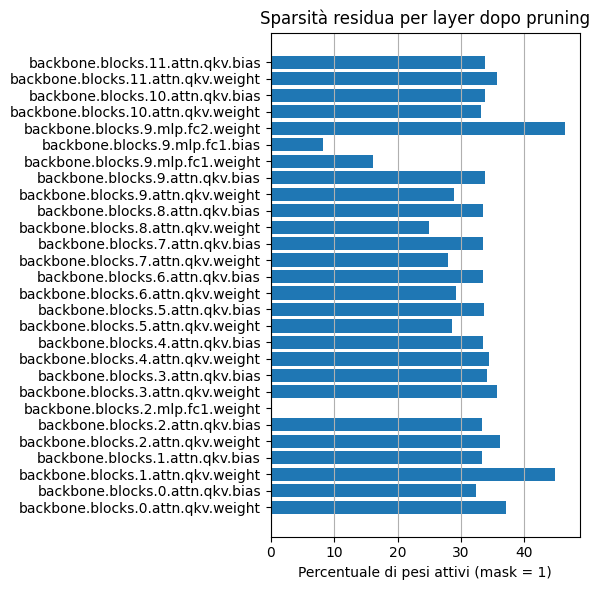

In [95]:
plot_all_layers_mask_sparsity(client_masks_non_iid_1[25])

In [96]:
# --- OPTIMIZER AND LOSS FUNCTION ---

num_rounds = 300
optimizer_config = {
  "lr" : 0.01,  # best hyperparameter of the centralized
  "momentum" : 0.9,
  "weight_decay" : 0.0001 # best hyperparameter of the centralized
}

num_clients = 100

# Default hyperparameters for FedAvg
num_local_steps = 4 # Fixed number of local steps
fraction = 0.1
criterion = nn.CrossEntropyLoss()
model_name = "dino_vits16_J4"

checkpoint_dir = "/content/drive/MyDrive/FL/FederatedLearningProject/checkpoints/FL/"
os.makedirs(checkpoint_dir, exist_ok=True)
# Make checkpoint path unique to the run if you want to store separate checkpoints
#checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_model_editing_iid.pth")
#checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_model_editing_iid_08.pth")
#checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_model_editing_iid_07.pth")


#checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_model_editing_non_iid_1.pth")
#checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_model_editing_non_iid_1_08.pth")
#checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_model_editing_non_iid_1_09.pth")
checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_model_editing_non_iid_1_09.pth")

#checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_model_editing_non_iid_5.pth")

#checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_model_editing_non_iid_10.pth")

#checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_model_editing_non_iid_50.pth")

In [12]:
wandb.login() # Ask for your APIw key for logging in to the wandb library.

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: depetrofabio (depetrofabio-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [102]:
device = "cuda"
project_name = "FedAvg_ModelEditing_Sparsities_NON_IID(1)"

# Generate a unique run name for each iteration
#run_name = f"{model_name}_FedAvg_model_editing_iid"
#run_name = f"{model_name}_FedAvg_model_editing_iid_sparsity_09"
#run_name = f"{model_name}_FedAvg_model_editing_iid_sparsity_07"
#run_name = f"{model_name}_FedAvg_model_editing_iid_sparsity_08"

#run_name = f"{model_name}_FedAvg_model_editing_non_iid_1"
run_name = f"{model_name}_FedAvg_model_editing_non_iid_1_sparsity_09"

#run_name = f"{model_name}_FedAvg_model_editing_non_iid_5"

#run_name = f"{model_name}_FedAvg_model_editing_non_iid_10"

#run_name = f"{model_name}_FedAvg_model_editing_non_iid_50"

# INITIALIZE W&B for each new run
wandb.init(
    project=project_name,
    name=run_name,
    config={
        "model": model_name,
        "num_rounds": 300, # Use the current num_rounds_val
        "batch_size": 128, # Using test_loader's batch_size as a placeholder
    },
    reinit=True # Important: Allows re-initialization of wandb in a loop
)

# Copy your config
config = wandb.config


client_avg_accuracy,▅▇▅▇▇▃▁▆▇▆▆▄▅▄▁▄▂▄▅▆▃▃▂▇▆▄▄█▄▄▅▅▃▅▇▆▄▆▆█
client_avg_loss,▆▃▄▄▃█▄▃▅▅▆▇▆▄▄▅▆▃▃▆▅█▂▁▆▅▄▁▅▂█▄▄▂▄▅▅▄▃▁
round,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
server_val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
server_val_loss,██▇▆▆▇▆▆▆▅▆▆▅▆▅▅▆▄▅▄▃▁▁▁▂▂▃▃▄▅▅▅▄▄▄▃▅▅▅▆
client_avg_accuracy,36.34207
client_avg_loss,4.12431
round,299
server_val_accuracy,32.38
server_val_loss,4.73316


In [103]:
model.unfreeze(12)
model.to_cuda()

moving model to cuda


In [104]:
train_server_model_editing(model=model,
             num_clients = 100,
             num_rounds=num_rounds,
             client_dataset = client_dataset_non_iid_1,
             frac=0.1,
             batch_size=128,
             client_masks = client_masks_non_iid_1,
             optimizer_config=optimizer_config,
             val_loader = val_loader,
             criterion = criterion,
             num_client_steps = 4,
             model_name = model_name,
             checkpoint_path = checkpoint_path,
             device = device)


--- Round 1/300 ---

--- Round 2/300 ---

--- Round 3/300 ---

--- Round 4/300 ---

--- Round 5/300 ---

Round 5/300
Selected Clients: [26 18 81 28 47 59 64 89 45 21]
Avg Client Loss: 4.2289 | Avg Client Accuracy: 32.31%
Evaluation Loss: 6.1150 | Val Accuracy: 10.43%
--------------------------------------------------

--- Round 6/300 ---

--- Round 7/300 ---

--- Round 8/300 ---

--- Round 9/300 ---

--- Round 10/300 ---

Round 10/300
Selected Clients: [11 23 99 43 60 34 70 86 97 39]
Avg Client Loss: 1.2210 | Avg Client Accuracy: 74.36%
Evaluation Loss: 4.2460 | Val Accuracy: 26.87%
--------------------------------------------------

--- Round 11/300 ---

--- Round 12/300 ---

--- Round 13/300 ---

--- Round 14/300 ---

--- Round 15/300 ---

Round 15/300
Selected Clients: [32 55  8 44 82  3 36 65 53 69]
Avg Client Loss: 1.8842 | Avg Client Accuracy: 65.21%
Evaluation Loss: 4.8179 | Val Accuracy: 19.94%
--------------------------------------------------

--- Round 16/300 ---

--- Round

{'model': LinearFlexibleDino(
   (backbone): VisionTransformer(
     (patch_embed): PatchEmbed(
       (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
     )
     (pos_drop): Dropout(p=0.0, inplace=False)
     (blocks): ModuleList(
       (0-11): 12 x Block(
         (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
         (attn): Attention(
           (qkv): Linear(in_features=384, out_features=1152, bias=True)
           (attn_drop): Dropout(p=0.0, inplace=False)
           (proj): Linear(in_features=384, out_features=384, bias=True)
           (proj_drop): Dropout(p=0.0, inplace=False)
         )
         (drop_path): Identity()
         (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
         (mlp): Mlp(
           (fc1): Linear(in_features=384, out_features=1536, bias=True)
           (act): GELU(approximate='none')
           (fc2): Linear(in_features=1536, out_features=384, bias=True)
           (drop): Dropout(p=0.0, inplace=False)
  

In [68]:
from FederatedLearningProject.training.FL_training import val

x = val(model, val_loader=val_loader, criterion=criterion, device="cuda")

In [69]:
x[1]

32.38

In [30]:
x[1]

44.6

In [27]:
y = val(model2, val_loader=val_loader, criterion=criterion, device="cuda")

In [28]:
y[1]

44.6